In [36]:
# ---- Imports ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from xgboost import XGBRegressor, plot_importance

import scipy
from scipy.sparse import issparse

from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.callbacks import VerboseCallback

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

from tqdm import tqdm

In [37]:
# ---- Load datasets ----

train_df = pd.read_csv('./data/train.csv')



In [38]:
# ---- Pipeline Initialization ----

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, current_year=2024, top_n_property_types=15, top_n_amenities=50):
        self.current_year = current_year # in case data was collected in different year

        # mapping response times to numerical values
        self.response_time_mapping = {
            'within an hour': 4,
            'within a few hours': 3,
            'within a day': 2,
            'a few days or more': 1
        }

        self.top_n_property_types = top_n_property_types
        self.top_property_types = []

        # room type mapping
        self.room_type_mapping = {
            'Entire home/apt': 3,
            'Private room': 2,
            'Hotel room': 1,
            'Shared room': 0
        }

        self.top_n_amenities = top_n_amenities
        self.top_amenities = []
        self.mlb = None 

        self.verification_types = []

    def clean_amenities(self, amenities_series):
        # Remove brackets and quotes, then split by comma
        cleaned_amenities = amenities_series.apply(
            lambda x: [amenity.strip().strip("'").strip('"') 
                    for amenity in x.strip('[]').split(',')]
        )
        return cleaned_amenities
    
    def clean_host_verifications(self, verifications_series):
        cleaned_verifications = verifications_series.apply(
            lambda x: [verification.strip().strip("'").strip('"') 
                    for verification in x.strip('[]').split(',')]
        )
        return cleaned_verifications

    def fit(self, X, y=None):
        # simplify property type using regex
        property_types_simplified = X['property_type'].str.replace(
            r'^(Entire |Private |Shared |Room in )', '', regex=True
        )
        # islolate top n property types
        self.top_property_types = property_types_simplified.value_counts().nlargest(self.top_n_property_types).index.tolist()

        # Process amenities
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        amenities = amenities_list.explode()
        self.top_amenities = amenities.value_counts().nlargest(self.top_n_amenities).index.tolist()

        # Initialize MultiLabelBinarizer with top amenities
        self.mlb = MultiLabelBinarizer(classes=self.top_amenities)
        self.mlb.fit(amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities]))

        if 'host_verifications' in X.columns:
            cleaned_verifications = self.clean_host_verifications(X['host_verifications'])
            unique_verifications = cleaned_verifications.explode().unique()
            self.verification_types = [v for v in unique_verifications if v]  # Exclude empty strings

        return self
    
    def transform(self, X):
        """
        Applies feature engineering transformations to the DataFrame.

        Parameters:
        - X (pd.DataFrame): The input DataFrame.

        Returns:
        - X (pd.DataFrame): The transformed DataFrame.
        """
        X = X.copy()

        # 1. Encode 'host_is_superhost' as binary
        if 'host_is_superhost' in X.columns:
            X['host_is_superhost_encoded'] = X['host_is_superhost'].astype(bool).astype(int)
        else:
            X['host_is_superhost_encoded'] = 0  # Default value if column is missing

        # 2. Ordinal encode 'host_response_time'
        if 'host_response_time' in X.columns:
            X['host_response_time_encoded'] = X['host_response_time'].map(self.response_time_mapping)
        else:
            X['host_response_time_encoded'] = self.response_time_mapping['a few days or more']  # Default value

        # 3. Encode 'room_type' as ordinal
        if 'room_type' in X.columns:
            X['room_type_encoded'] = X['room_type'].map(self.room_type_mapping)
        else:
            X['room_type_encoded'] = 0  # Default value

        # 4. Convert 'host_since' to 'host_years'
        if 'host_since' in X.columns:
            X['host_since'] = pd.to_datetime(X['host_since'], errors='coerce')
            X['host_years'] = self.current_year - X['host_since'].dt.year
            X['host_years'] = X['host_years'].fillna(0).astype(int)  # Handle NaT
        else:
            X['host_years'] = 0  # Default value

        # 5. Fill missing 'neighbourhood_group_cleansed' with 'Unknown'
        if 'neighbourhood_group_cleansed' in X.columns:
            X['neighbourhood_group_cleansed'] = X['neighbourhood_group_cleansed'].fillna('Unknown')
        else:
            X['neighbourhood_group_cleansed'] = 'Unknown'  # Default value

        # 6. Add 'has_review' feature
        if 'reviews' in X.columns:
            X['has_review'] = X['reviews'].apply(lambda x: 0 if pd.isna(x) or len(str(x).strip()) == 0 else 1)
        else:
            X['has_review'] = 0  # Default value

        # days since last review
        if 'last_review' in X.columns:
            X['last_review'] = pd.to_datetime(X['last_review'], errors='coerce')
            X['days_since_last_review'] = (pd.Timestamp.now() - X['last_review']).dt.days
            X['days_since_last_review'] = X['days_since_last_review'].fillna(0).astype(int)

        # days since first review
        if 'first_review' in X.columns:
            X['first_review'] = pd.to_datetime(X['first_review'], errors='coerce')
            X['days_since_first_review'] = (pd.Timestamp.now() - X['first_review']).dt.days
            X['days_since_first_review'] = X['days_since_first_review'].fillna(0).astype(int)

        # 9. Process 'amenities' and binarize
        amenities_list = self.clean_amenities(X['amenities'].fillna(''))
        X['amenities_simplified'] = amenities_list.apply(lambda x: [i for i in x if i in self.top_amenities])

        # Binarize the amenities
        amenities_binarized = self.mlb.transform(X['amenities_simplified'])
        amenities_df = pd.DataFrame(amenities_binarized, columns=self.mlb.classes_, index=X.index)
        X = pd.concat([X, amenities_df], axis=1)

        # 7. Simplify 'property_type' by removing room type prefixes
        if 'property_type' in X.columns:
            X['property_type_simplified'] = X['property_type'].str.replace(
                r'^(Entire |Private |Shared |Room in )', '', regex=True
            )
        else:
            X['property_type_simplified'] = 'Other'  # Default value

        # 8. Group 'property_type' into top N and 'Other'
        X['property_type_grouped'] = X['property_type_simplified'].apply(
            lambda x: x if x in self.top_property_types else 'Other'
        )

        # 10. Process 'host_verifications' and binarize
        if 'host_verifications' in X.columns:
            cleaned_verifications = self.clean_host_verifications(X['host_verifications'])
            # column for phone, email, work_email
            for verification in self.verification_types:
                X[f'{verification}_verification'] = cleaned_verifications.apply(
                    lambda x: 1 if verification in x else 0
                )
            
        # 11. bathroom shared or not. look at text for word shared. if null then 0
        if 'bathrooms_text' in X.columns:
            X['bathrooms_shared'] = X['bathrooms_text'].fillna('').str.contains('shared').astype(int)
        else:
            X['bathrooms_shared'] = 0

        # bedroom/bathroom ratio
        if 'bedrooms' in X.columns and 'bathrooms' in X.columns:
            X['bed_bath_ratio'] = X['bedrooms'] / X['bathrooms']
            X['bed_bath_ratio'] = X['bed_bath_ratio'].replace([np.inf, -np.inf], np.nan)
            X['bed_bath_ratio'] = X['bed_bath_ratio'].fillna(0)

        # 9. Drop original columns that have been engineered
        columns_to_drop = [
            'host_is_superhost', 'host_response_time', 'room_type',
            'host_since', 'property_type'
        ]
        X.drop(columns=[col for col in columns_to_drop if col in X.columns], inplace=True)


        return X

In [39]:
# ---- Data Preprocessing ----

# Instantiate FeatureEngineer to access top amenities after fitting
feature_engineer = FeatureEngineer()

# Fit the FeatureEngineer on the training data to get the amenity feature names
feature_engineer.fit(train_df)

# Extract amenity feature names
amenity_features = feature_engineer.mlb.classes_.tolist()

# seperate feature types
numerical_features = [
    'latitude', 'longitude', 'host_listings_count', 'host_total_listings_count',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'maximum_nights',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'host_acceptance_rate',
    'reviews_per_month',
    'host_years',  # Newly added numerical feature
    'days_since_last_review',
    'days_since_first_review',
    'has_review',  # Move 'has_review' here since it's binary numerical
    'bed_bath_ratio',
    'room_type_encoded',                      # Transformed categorical feature
    'host_response_time_encoded',             # Transformed categorical feature
    'minimum_nights'


] + amenity_features  # Include amenity features

categorical_features = [
    'has_availability', 'neighbourhood_group_cleansed',
    'neighbourhood_cleansed',
    'property_type_grouped',                  # Transformed categorical feature
]

binary_features = [
    'has_review',                              # Newly added binary feature
    'bathrooms_shared',                     # Newly added binary feature
    'host_is_superhost_encoded',              # Transformed categorical feature
    'email_verification',
    'phone_verification',
    'work_email_verification',
    'instant_bookable',
    'host_has_profile_pic',
]

# print features in train_df that are not in numerical_features or categorical_features
print(set(train_df.columns) - set(numerical_features + categorical_features + binary_features))

# features in categorical and numerical features that are not in train_df
print(set(numerical_features + categorical_features + binary_features) - set(train_df.columns))

# define preprocessing for numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=5,  # Adjust based on your data
    ))
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# combine preprocessing steps
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features),
    ('binary', binary_pipeline, binary_features)
], remainder='drop')

# create full pipeline
pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        colsample_bytree=0.6,
        learning_rate=0.007842626275244038,
        max_depth=8,
        n_estimators=4327,
        min_child_weight=1,
        subsample=0.7820197885961735,
        gamma=0.0,
        reg_alpha=0.26688146967018384,
        reg_lambda=1.0,
        eval_metric='rmse'
    ))
])

{'price', 'host_since', 'name', 'property_type', 'host_identity_verified', 'room_type', 'host_response_rate', 'reviews', 'description', 'amenities', 'last_review', 'bathrooms_text', 'host_response_time', 'host_verifications', 'first_review', 'host_is_superhost'}
{'Room-darkening shades', 'Hangers', 'First aid kit', 'Hot water', 'Hot water kettle', 'Smoke alarm', 'bathrooms_shared', 'property_type_grouped', 'Dishwasher', 'work_email_verification', 'Shampoo', 'Coffee maker', 'Luggage dropoff allowed', 'Private entrance', 'phone_verification', 'Oven', 'email_verification', 'Coffee', 'Heating', 'Washer', 'bed_bath_ratio', 'host_response_time_encoded', 'Bed linens', 'Cooking basics', 'Cleaning products', 'has_review', 'Freezer', 'Laundromat nearby', 'Fire extinguisher', 'Wine glasses', 'Stove', 'Bathtub', 'Shower gel', 'Free street parking', 'Refrigerator', 'host_years', 'Iron', 'Body soap', 'Extra pillows and blankets', 'TV', 'Wifi', 'Toaster', 'Hair dryer', 'days_since_last_review', 'Micr

In [40]:
# Load train data
X = train_df.drop(columns=['price'])
y = train_df['price']

# ---- Split the Data into Training and Testing Sets ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# ---- Fit the Pipeline on the Training Data ----
pipeline.fit(X_train, y_train)

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this number for quicker testing

# Initialize the K-Fold cross-validator
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

# Perform cross-validation on the training data
cv_scores = cross_val_score(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',  # Use negative RMSE as scoring
    cv=kf,
    n_jobs=-1,
    verbose=1
)

# Convert scores to positive values
cv_rmse_scores = -cv_scores

# Calculate mean and standard deviation of RMSE scores
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f'Cross-Validation RMSE Scores: {cv_rmse_scores}')
print(f'Mean CV RMSE: {mean_cv_rmse:.4f}')
print(f'Standard Deviation of CV RMSE: {std_cv_rmse:.4f}')

# ---- Evaluate the Model on the Test Set ----
# Predict on the test set
y_test_pred = pipeline.predict(X_test)

# Calculate RMSE on the test set
test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
print(f'Test RMSE: {test_rmse:.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Cross-Validation RMSE Scores: [0.70476206 0.73921156 0.70502647 0.71304564 0.72398975]
Mean CV RMSE: 0.7172
Standard Deviation of CV RMSE: 0.0130
Test RMSE: 0.7059


In [41]:
%%timeit 

pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)

The slowest run took 4.34 times longer than the fastest. This could mean that an intermediate result is being cached.
59.9 s ± 31.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
# ---- Model Info ----

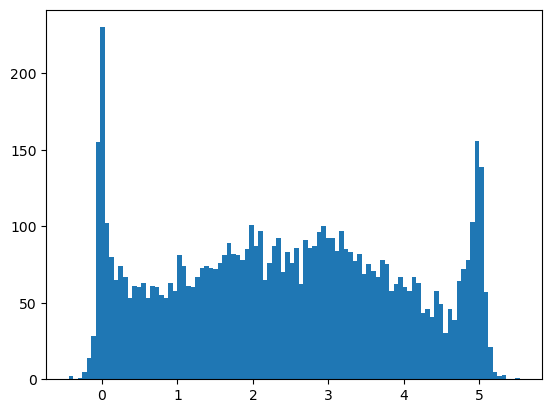

In [43]:
# ---- Exporting test results ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = pipeline.predict(test_df)

# plot histogram distribution of outputs
plt.hist(y_test_pred, bins=100)
plt.show()

# round to nearest integer
y_test_pred = np.round(y_test_pred, 0).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

In [44]:
# ---- Feature Importance ----
# Function to get feature names from the ColumnTransformer
def get_feature_names(column_transformer):
    feature_names = []

    # Retrieve transformer list
    for name, transformer, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                # If the transformer has get_feature_names_out, use it
                transformed_features = transformer.get_feature_names_out(features)
            else:
                # If not, use the original feature names
                transformed_features = features
            feature_names.extend(transformed_features)
        elif transformer == 'passthrough':
            # Append passthrough features
            feature_names.extend(features)
    return feature_names

# Get feature names from the preprocessor
preprocessor = pipeline.named_steps['preprocessor']
feature_names = get_feature_names(preprocessor)

# Print the total number of features after preprocessing
print(f'Total number of features: {len(feature_names)}')

Total number of features: 284


In [45]:
# Perform permutation importance on the test set
perm_importance = permutation_importance(
    pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=0,
    scoring='neg_root_mean_squared_error'
)

# Get the importance scores
perm_importance_mean = perm_importance.importances_mean

# Create a DataFrame for visualization
perm_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance_mean
})

# Sort features by importance
perm_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
perm_importance_df.head(20)

,Feature,Importance
34,minimum_nights,0.260499
6,longitude,0.179150
21,room_type,0.158090
22,accommodates,0.117591
27,amenities,0.095421
5,latitude,0.076197
24,bathrooms_text,0.059822
25,bedrooms,0.050459
13,host_total_listings_count,0.033391
19,calculated_host_listings_count_private_rooms,0.028595


In [46]:
# Get the trained model from the pipeline
model = pipeline.named_steps['model']

# Retrieve feature importances from the model
importances = model.feature_importances_

# Create a DataFrame for visualization
import pandas as pd

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the top 20 most important features
feature_importance_df.head(20)

,Feature,Importance
34,room_type_encoded,0.201915
277,bathrooms_shared,0.122456
265,property_type_grouped_hotel,0.056942
36,minimum_nights,0.044294
271,property_type_grouped_room in rental unit,0.025053
90,neighbourhood_group_cleansed_Manhattan,0.023372
8,accommodates,0.013688
77,Dishwasher,0.013499
261,property_type_grouped_boutique hotel,0.012608
6,calculated_host_listings_count_private_rooms,0.011615


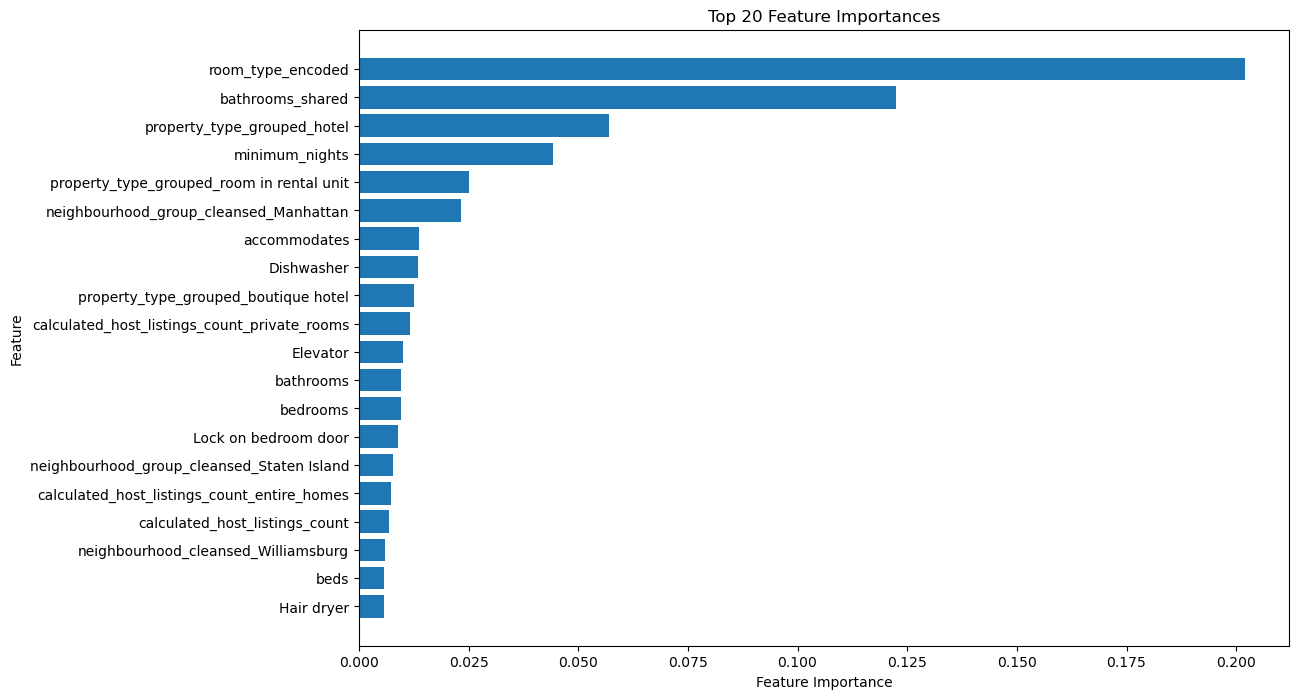

In [47]:
import matplotlib.pyplot as plt

# Plot the top 20 most important features
top_n = 20  # Number of top features to display
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(y=top_features['Feature'][::-1], width=top_features['Importance'][::-1])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances')
plt.show()

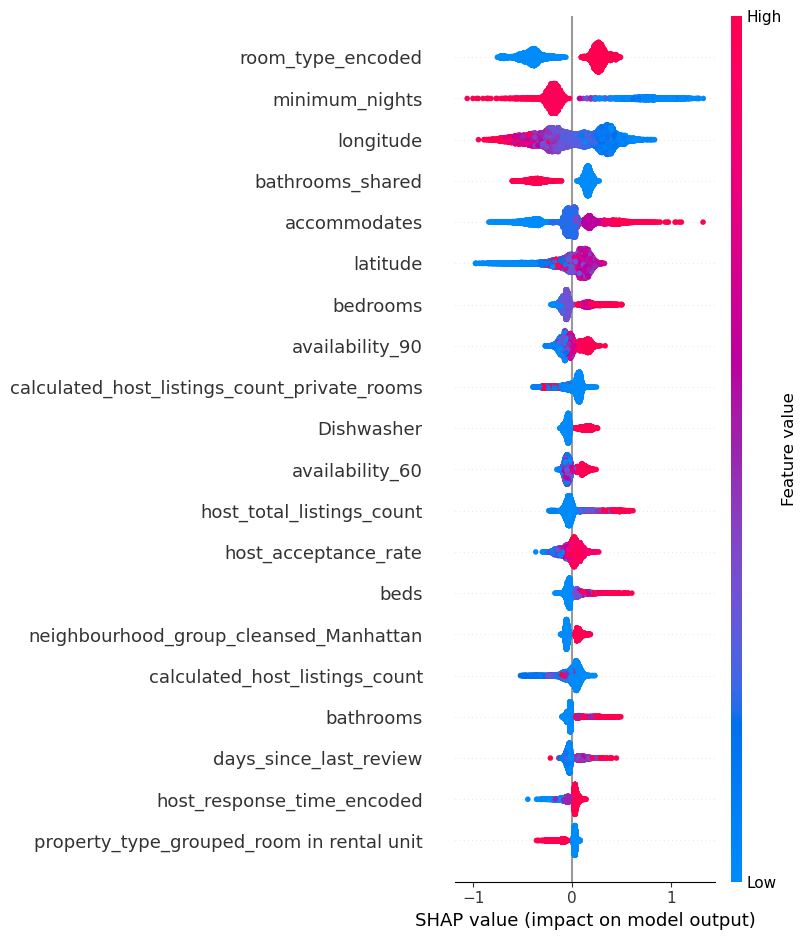

In [48]:
# Apply the FeatureEngineer transformation to the entire dataset
X_train_fe = pipeline.named_steps['feature_engineer'].transform(X_train)

# Apply the preprocessor transformation
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train_fe)

# Convert to dense array if necessary
if isinstance(X_train_transformed, scipy.sparse.spmatrix):
    X_train_transformed = X_train_transformed.toarray()

# Retrieve feature names
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            feature_names.extend(columns)
        else:
            if isinstance(transformer, Pipeline):
                # Get the last transformer in the pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names_out'):
                # For transformers that support get_feature_names_out
                names = transformer.get_feature_names_out(columns)
            else:
                # Fallback to the original column names
                names = columns

            feature_names.extend(names)

    return feature_names

# Get feature names
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

# Ensure the number of features match
assert X_train_transformed.shape[1] == len(feature_names), "Mismatch between data and feature names"

# Create DataFrame of transformed features
X_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# Get the trained model
model = pipeline.named_steps['model']

# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# Plot the SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_transformed_df)

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 1,000 observations
n_samples = 1000
random_indices = np.random.choice(X_transformed_df.index, n_samples, replace=False)
random_indices = [0, 1, 2]

# Subset the data and SHAP values
X_subset = X_transformed_df.iloc[random_indices]

if isinstance(shap_values, list):
    # For multiclass classification
    class_index = 0  # Change this to the desired class index
    shap_values_subset = shap_values[class_index][random_indices]
    expected_value = explainer.expected_value[class_index]
else:
    # For regression or binary classification
    shap_values_subset = shap_values[random_indices]
    expected_value = explainer.expected_value

# print top 10 most important features
top_features = feature_importance_df.head(10)
print(top_features)



                                          Feature  Importance
34                              room_type_encoded    0.201915
277                              bathrooms_shared    0.122456
265                   property_type_grouped_hotel    0.056942
36                                 minimum_nights    0.044294
271     property_type_grouped_room in rental unit    0.025053
90         neighbourhood_group_cleansed_Manhattan    0.023372
8                                    accommodates    0.013688
77                                     Dishwasher    0.013499
261          property_type_grouped_boutique hotel    0.012608
6    calculated_host_listings_count_private_rooms    0.011615


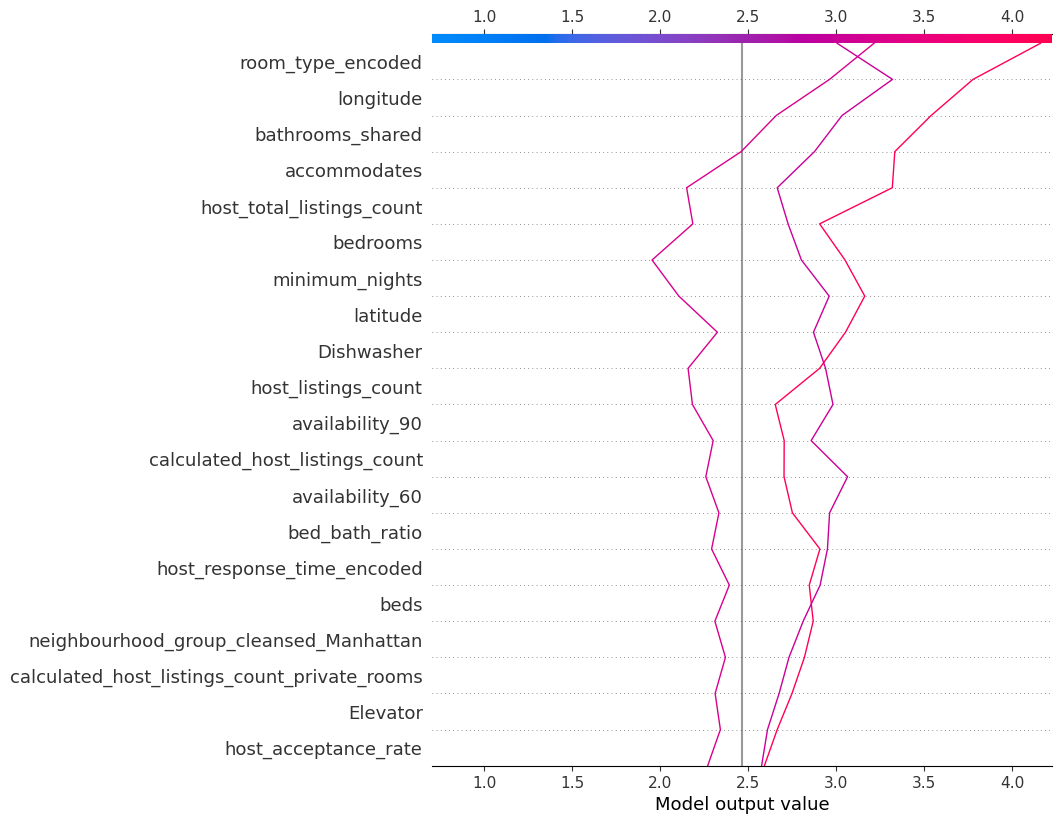

In [58]:
# Plot the SHAP decision plot for the random subset
plt.figure(figsize=(12, 8))
shap.decision_plot(expected_value, shap_values_subset, X_subset)

In [50]:
# ---- Model Info ----
# get the names of featuers
feature_names = get_feature_names(pipeline.named_steps['preprocessor'])
# print number
print(f"Feature names: {feature_names}")
print(f"Number of features: {len(feature_names)}")

print()

# check which featues were added during preprocessing
added_features = set(feature_names) - set(train_df.columns)
print(f"Added features: {added_features}")
print(f"Number of added features: {len(added_features)}")

# features in the original data that were not used in the model
unused_features = set(train_df.columns) - set(feature_names)
print(f"Unused features: {unused_features}")
print(f"Number of unused features: {len(unused_features)}")

Feature names: ['latitude', 'longitude', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'host_acceptance_rate', 'reviews_per_month', 'host_years', 'days_since_last_review', 'days_since_first_review', 'has_review', 'bed_bath_ratio', 'room_type_encoded', 'host_response_time_encoded', 'minimum_nights', 'Smoke alarm', 'Wifi', 'Carbon monoxide alarm', 'Kitchen', 'Hot water', 'Essentials', 'Hangers', 'Hair dryer', 'Iron',

In [51]:
# 

In [52]:
# -- SHAP Value Interpretation --
# how many shap importance values are greater than 0.01
n_features = (np.abs(shap_values).mean(0) > 0.05).sum()
print(f'Number of features with |SHAP| > 0.01: {n_features}')

Number of features with |SHAP| > 0.01: 20


In [53]:
# drop features with low importance
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_shap_values})

# Sort by importance
shap_df.sort_values(by='Importance', ascending=True, inplace=True)

# Filter features below the threshold
threshold = 0.01  # Adjust threshold
features_to_keep_df = shap_df[shap_df['Importance'] > threshold]['Feature']

# print features to keep ordered by importance
print(features_to_keep_df)
print(features_to_keep_df.shape)

features_to_keep = features_to_keep_df.tolist()

print(shap_df.columns)

print(f'Number of features to keep: {len(features_to_keep) / len(feature_names) * 100:.2f}%')
print(f'Features to keep: {features_to_keep}')

73                                Laundromat nearby
267               property_type_grouped_rental unit
282                                instant_bookable
52                              Dedicated workspace
50                                   Cooking basics
281                         work_email_verification
53                                        Microwave
254             neighbourhood_cleansed_Williamsburg
71                                     Wine glasses
17                                number_of_reviews
265                     property_type_grouped_hotel
278                       host_is_superhost_encoded
16                                   maximum_nights
57                                    Self check-in
21                           review_scores_accuracy
28                                reviews_per_month
55                                          Shampoo
29                                       host_years
81                                     Pets allowed
25          

In [54]:
# feature importance of features starting with 'bathroom_text'
bathroom_text_features = [feature for feature in feature_names if feature.startswith('bathrooms')]
bathroom_text_importance = shap_df[shap_df['Feature'].isin(bathroom_text_features)]
print(f"Bathroom text features importance: {bathroom_text_importance}")

# check cleaned host verifications
host_verification_features = [feature for feature in feature_names if feature.startswith('cleaned_host_verifications')]
host_verification_importance = shap_df[shap_df['Feature'].isin(host_verification_features)]
print(f"Host verification features importance: {host_verification_importance}")

Bathroom text features importance:               Feature  Importance
9           bathrooms     0.05773
277  bathrooms_shared     0.21138
Host verification features importance: Empty DataFrame
Columns: [Feature, Importance]
Index: []


In [55]:
# modify the pipeline to include only the important features
class FeatureFilter(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_keep):
        self.features_to_keep = features_to_keep

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X_filtered = X[:, self.feature_indices]

        # Debugging: Print shape after filtering
        print(f"Filtered shape: {X_filtered.shape}")

        return X_filtered
    
pipeline_with_filter = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', preprocessor),
    ('feature_filter', FeatureFilter(features_to_keep)),  # Filter selected features
    ('model', XGBRegressor(
        colsample_bytree=0.7896615860728206,
        learning_rate=0.02157373365594319,
        max_depth=8,
        n_estimators=1617,
        min_child_weight=10,
        subsample=0.6,
        eval_metric='rmse'
    ))
])

# # evaluate
# y_test_pred_filtered = pipeline_with_filter.predict(X_test)
# test_rmse_filtered = np.sqrt(np.mean((y_test - y_test_pred_filtered) ** 2))
# print(f'Test RMSE after feature filtering: {test_rmse_filtered:.4f}')

# # print number of features
# print(f"Number of features: {len(features_to_keep)}")

In [57]:
# ---- Hyperparameter Tuning ----
# Define the parameter search space with improved ranges
param_space = {
    'model__n_estimators': Integer(1000, 5000),
    'model__max_depth': Integer(2, 15),
    'model__learning_rate': Real(0.005, 0.4, prior='log-uniform'),
    'model__subsample': Real(0.6, 1.0, prior='uniform'),
    'model__colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'model__min_child_weight': Integer(1, 10),
    'model__gamma': Real(0.0, 0.5, prior='uniform'),
    'model__reg_alpha': Real(0.0, 1.0, prior='uniform'),
    'model__reg_lambda': Real(0.0, 1.0, prior='uniform'),
}

# Update the model in the pipeline to include early stopping
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_jobs=-1,
    random_state=0
)

pipeline.steps[-1] = ('model', xgb_model)  # Replace the model in the pipeline

# Initialize Bayesian search with improvements
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=5,           # Increased iterations for better exploration
    cv=5,                # Reduced to 3-fold CV for speed
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=0,
    verbose=0,           # Increased verbosity for monitoring
    refit=True,          # Refit the best model on the whole dataset at the end
)

print('Type of X:', type(X))
print('Type of y:', type(y))

# Fit the Bayesian search
bayes_search.fit(X, y)

# Best parameters
print("Best Parameters:")
print(bayes_search.best_params_)

# Best CV score
best_rmse = -bayes_search.best_score_
print(f'Best CV RMSE: {best_rmse:.4f}')

Type of X: <class 'pandas.core.frame.DataFrame'>
Type of y: <class 'pandas.core.series.Series'>
Best Parameters:
OrderedDict({'model__colsample_bytree': 0.6589679247804687, 'model__gamma': 0.3916331353364969, 'model__learning_rate': 0.03920268401060082, 'model__max_depth': 8, 'model__min_child_weight': 8, 'model__n_estimators': 3715, 'model__reg_alpha': 0.8459653268113954, 'model__reg_lambda': 0.3194391938101548, 'model__subsample': 0.7537050401966815})
Best CV RMSE: 0.7125


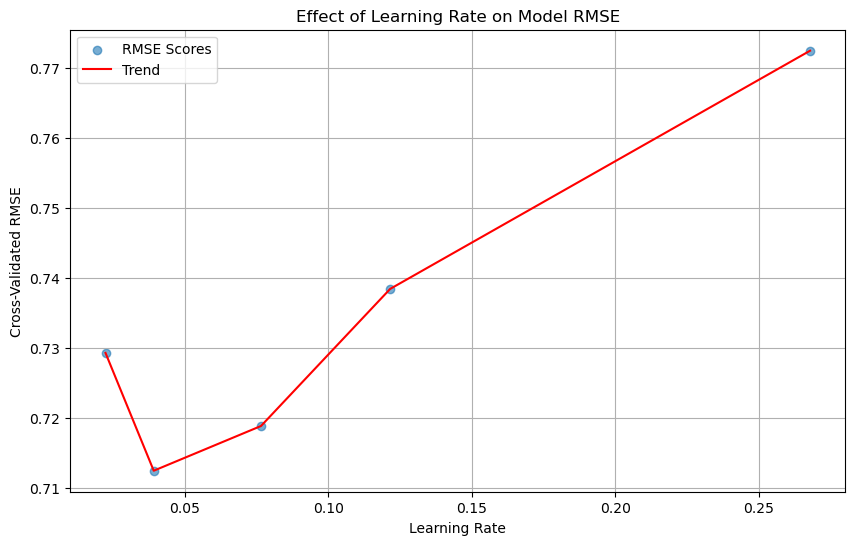

In [ ]:
# ---- Visualization: Hyperparameter vs. RMSE ----

# Select the hyperparameter to plot
# Example: 'model__learning_rate'
hyperparameter = 'model__learning_rate'

# Extract results
results = bayes_search.cv_results_

# Extract hyperparameter values and corresponding RMSE scores
# Note: scores are negative RMSE, so we take the negative to get actual RMSE
param_values = results['param_model__learning_rate'].data
rmse_scores = -results['mean_test_score']

# Create a DataFrame for easier plotting (optional but recommended)
import pandas as pd

df_plot = pd.DataFrame({
    hyperparameter: param_values,
    'RMSE': rmse_scores
})

# Sort the DataFrame by hyperparameter for better visualization
df_plot_sorted = df_plot.sort_values(by=hyperparameter)

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(param_values, rmse_scores, alpha=0.6, label='RMSE Scores')
plt.plot(df_plot_sorted[hyperparameter], df_plot_sorted['RMSE'], color='red', label='Trend')
plt.xlabel('Learning Rate')
plt.ylabel('Cross-Validated RMSE')
plt.title('Effect of Learning Rate on Model RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ---- Exporting test results using best model ----
test_df = pd.read_csv('./data/test.csv')

# predict
y_test_pred = bayes_search.predict(test_df)

# round
y_test_pred = np.clip(np.round(y_test_pred), 0, 5).astype(int)

# save to csv
test_df['price'] = y_test_pred
test_df[['id', 'price']].to_csv('./data/test_results.csv', index=False)

/Users/michaelscutari/micromamba/envs/cs671/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# time to train the model with iterations
%timeit bayes_search.fit(X, y)

NameError: name 'bayes_search' is not defined